# Build a Retrieval Augmented Generation (RAG) App: Part 1

One of the most powerful applications enabled by LLMs is sophisticated question-answering (Q&A) chatbots. These are applications that can answer questions about specific source information. These applications use a technique known as Retrieval Augmented Generation, or [RAG](/docs/concepts/rag/).

This is a multi-part tutorial:

- [Part 1](/docs/tutorials/rag) (this guide) introduces RAG and walks through a minimal implementation.
- [Part 2](/docs/tutorials/qa_chat_history) extends the implementation to accommodate conversation-style interactions and multi-step retrieval processes.

This tutorial will show how to build a simple Q&A application
over a text data source. Along the way we’ll go over a typical Q&A
architecture and highlight additional resources for more advanced Q&A techniques. We’ll also see
how LangSmith can help us trace and understand our application.
LangSmith will become increasingly helpful as our application grows in
complexity.

If you're already familiar with basic retrieval, you might also be interested in
this [high-level overview of different retrieval techinques](/docs/concepts/retrieval).

**Note**: Here we focus on Q&A for unstructured data. If you are interested for RAG over structured data, check out our tutorial on doing [question/answering over SQL data](/docs/tutorials/sql_qa).

## Overview
A typical RAG application has two main components:

**Indexing**: a pipeline for ingesting data from a source and indexing it. *This usually happens offline.*

**Retrieval and generation**: the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.

Note: the indexing portion of this tutorial will largely follow the [semantic search tutorial](/docs/tutorials/retrievers).

The most common full sequence from raw data to answer looks like:

### Indexing
1. **Load**: First we need to load our data. This is done with [Document Loaders](/docs/concepts/document_loaders).
2. **Split**: [Text splitters](/docs/concepts/text_splitters) break large `Documents` into smaller chunks. This is useful both for indexing data and passing it into a model, as large chunks are harder to search over and won't fit in a model's finite context window.
3. **Store**: We need somewhere to store and index our splits, so that they can be searched over later. This is often done using a [VectorStore](/docs/concepts/vectorstores) and [Embeddings](/docs/concepts/embedding_models) model.

![index_diagram](../../static/img/rag_indexing.png)

### Retrieval and generation
4. **Retrieve**: Given a user input, relevant splits are retrieved from storage using a [Retriever](/docs/concepts/retrievers).
5. **Generate**: A [ChatModel](/docs/concepts/chat_models) / [LLM](/docs/concepts/text_llms) produces an answer using a prompt that includes both the question with the retrieved data

![retrieval_diagram](../../static/img/rag_retrieval_generation.png)

Once we've indexed our data, we will use [LangGraph](https://langchain-ai.github.io/langgraphjs/) as our orchestration framework to implement the retrieval and generation steps.

## Setup

### Jupyter Notebook

This and other tutorials are perhaps most conveniently run in a [Jupyter notebooks](https://jupyter.org/). Going through guides in an interactive environment is a great way to better understand them. See [here](https://jupyter.org/install) for instructions on how to install.

### Installation

To install LangChain run:

```bash npm2yarn
npm i langchain @langchain/core
```

For more details, see our [Installation guide](/docs/how_to/installation).

### LangSmith

Many of the applications you build with LangChain will contain multiple steps with multiple invocations of LLM calls.
As these applications get more and more complex, it becomes crucial to be able to inspect what exactly is going on inside your chain or agent.
The best way to do this is with [LangSmith](https://smith.langchain.com).

After you sign up at the link above, make sure to set your environment variables to start logging traces:

```shell
export LANGCHAIN_TRACING_V2="true"
export LANGCHAIN_API_KEY="..."

# Reduce tracing latency if you are not in a serverless environment
# export LANGCHAIN_CALLBACKS_BACKGROUND=true
```

## Components

We will need to select three components from LangChain's suite of integrations.

A [chat model](/docs/integrations/chat/):

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />

In [2]:
// @lc-docs-hide-cell
import { ChatOpenAI } from '@langchain/openai';

const llm = new ChatOpenAI({
  model: "gpt-4o-mini",
  temperature: 0,
})

An [embedding model](/docs/integrations/text_embedding/):

import EmbeddingTabs from "@theme/EmbeddingTabs";

<EmbeddingTabs/>

In [3]:
// @lc-docs-hide-cell
import { OpenAIEmbeddings } from "@langchain/openai";

const embeddings = new OpenAIEmbeddings({model: "text-embedding-3-large"});

And a [vector store](/docs/integrations/vectorstores/):

import VectorStoreTabs from "@theme/VectorStoreTabs";

<VectorStoreTabs/>

In [4]:
// @lc-docs-hide-cell
import { MemoryVectorStore } from "langchain/vectorstores/memory";

const vectorStore = new MemoryVectorStore(embeddings);

## Preview

In this guide we’ll build an app that answers questions about the website's content. The specific website we will use is the [LLM Powered Autonomous
Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) blog post
by Lilian Weng, which allows us to ask questions about the contents of
the post.

We can create a simple indexing pipeline and RAG chain to do this in ~50
lines of code.

```javascript
import "cheerio";
import { CheerioWebBaseLoader } from "@langchain/community/document_loaders/web/cheerio";
import { Document } from "@langchain/core/documents";
import { ChatPromptTemplate } from "@langchain/core/prompts";
import { pull } from "langchain/hub";
import { Annotation, StateGraph } from "@langchain/langgraph";
import { RecursiveCharacterTextSplitter } from "@langchain/textsplitters";


// Load and chunk contents of blog
const pTagSelector = "p";
const cheerioLoader = new CheerioWebBaseLoader(
  "https://lilianweng.github.io/posts/2023-06-23-agent/",
  {
    selector: pTagSelector
  }
);

const docs = await cheerioLoader.load();

const splitter = new RecursiveCharacterTextSplitter({
  chunkSize: 1000, chunkOverlap: 200
});
const allSplits = await splitter.splitDocuments(docs);


// Index chunks
await vectorStore.addDocuments(allSplits)

// Define prompt for question-answering
const promptTemplate = await pull<ChatPromptTemplate>("rlm/rag-prompt");

// Define state for application
const InputStateAnnotation = Annotation.Root({
  question: Annotation<string>,
});

const StateAnnotation = Annotation.Root({
  question: Annotation<string>,
  context: Annotation<Document[]>,
  answer: Annotation<string>,
});

// Define application steps
const retrieve = async (state: typeof InputStateAnnotation.State) => {
  const retrievedDocs = await vectorStore.similaritySearch(state.question)
  return { context: retrievedDocs };
};


const generate = async (state: typeof StateAnnotation.State) => {
  const docsContent = state.context.map(doc => doc.pageContent).join("\n");
  const messages = await promptTemplate.invoke({ question: state.question, context: docsContent });
  const response = await llm.invoke(messages);
  return { answer: response.content };
};


// Compile application and test
const graph = new StateGraph({
  input: InputStateAnnotation,
  output: StateAnnotation,
  stateSchema: StateAnnotation,
})
  .addNode("retrieve", retrieve)
  .addNode("generate", generate)
  .addEdge("__start__", "retrieve")
  .addEdge("retrieve", "generate")
  .addEdge("generate", "__end__")
  .compile();
```

```javascript
let inputs = { question: "What is Task Decomposition?" };

const result = await graph.invoke(inputs);
console.log(result.answer)
```

```
Task decomposition is the process of breaking down complex tasks into smaller, more manageable steps. This can be achieved through various methods, including prompting large language models (LLMs) or using task-specific instructions. Techniques like Chain of Thought (CoT) and Tree of Thoughts further enhance this process by structuring reasoning and exploring multiple possibilities at each step.
```

Check out the [LangSmith
trace](https://smith.langchain.com/public/84a36239-b466-41bd-ac84-befc33ab50df/r).

## Detailed walkthrough

Let’s go through the above code step-by-step to really understand what’s
going on.

## 1. Indexing {#indexing}

:::note

This section is an abbreviated version of the content in the [semantic search tutorial](/docs/tutorials/retrievers).
If you're comfortable with [document loaders](/docs/concepts/document_loaders), [embeddings](/docs/concepts/embedding_models), and [vector stores](/docs/concepts/vectorstores),
feel free to skip to the next section on [retrieval and generation](/docs/tutorials/rag/#orchestration).

:::

### Loading documents

We need to first load the blog post contents. We can use [DocumentLoaders](/docs/concepts/document_loaders) for this, which are objects that load in data from a source and return a list of [Documents](https://api.js.langchain.com/classes/langchain_core.documents.Document.html). A Document is an object with some pageContent (`string`) and metadata (`Record<string, any>`).

In this case we’ll use the [CheerioWebBaseLoader](https://api.js.langchain.com/classes/langchain.document_loaders_web_cheerio.CheerioWebBaseLoader.html), which uses cheerio to load HTML form web URLs and parse it to text. We can pass custom selectors to the constructor to only parse specific elements:

In [5]:
import "cheerio";
import { CheerioWebBaseLoader } from "@langchain/community/document_loaders/web/cheerio";

const pTagSelector = "p";
const cheerioLoader = new CheerioWebBaseLoader(
  "https://lilianweng.github.io/posts/2023-06-23-agent/",
  {
    selector: pTagSelector
  }
);

const docs = await cheerioLoader.load();

console.assert(docs.length === 1);
console.log(`Total characters: ${docs[0].pageContent.length}`);

Total characters: 22360


In [6]:
console.log(docs[0].pageContent.slice(0, 500));

Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:A complicated task usually involv


#### Go deeper

`DocumentLoader`: Class that loads data from a source as list of Documents.

- [Docs](/docs/concepts/document_loaders): Detailed documentation on how to use
- [Integrations](/docs/integrations/document_loaders/)
- [Interface](https:/api.js.langchain.com/classes/langchain.document_loaders_base.BaseDocumentLoader.html): API reference for the base interface.

### Splitting documents

Our loaded document is over 42k characters which is too long to fit
into the context window of many models. Even for those models that could
fit the full post in their context window, models can struggle to find
information in very long inputs.

To handle this we’ll split the `Document` into chunks for embedding and
vector storage. This should help us retrieve only the most relevant parts
of the blog post at run time.

As in the [semantic search tutorial](/docs/tutorials/retrievers), we use a
[RecursiveCharacterTextSplitter](/docs/how_to/recursive_text_splitter),
which will recursively split the document using common separators like
new lines until each chunk is the appropriate size. This is the
recommended text splitter for generic text use cases.

In [7]:
import { RecursiveCharacterTextSplitter } from "@langchain/textsplitters";

const splitter = new RecursiveCharacterTextSplitter({
  chunkSize: 1000, chunkOverlap: 200
});
const allSplits = await splitter.splitDocuments(docs);
console.log(`Split blog post into ${allSplits.length} sub-documents.`);

Split blog post into 29 sub-documents.


#### Go deeper

`TextSplitter`: Object that splits a list of `Document`s into smaller chunks. Subclass of `DocumentTransformers`.
- Explore `Context-aware splitters`, which keep the location (“context”) of each split in the original `Document`: - [Markdown files](/docs/how_to/code_splitter/#markdown) - [Code](/docs/how_to/code_splitter/) (15+ langs) - [Interface](https://api.js.langchain.com/classes/langchain_textsplitters.TextSplitter.html): API reference for the base interface.

`DocumentTransformer`: Object that performs a transformation on a list of `Document`s. - Docs: Detailed documentation on how to use `DocumentTransformer`s - [Integrations](/docs/integrations/document_transformers) - [Interface](https://api.js.langchain.com/classes/langchain_core.documents.BaseDocumentTransformer.html): API reference for the base interface.

### Storing documents

Now we need to index our 66 text chunks so that we can search over them
at runtime. Following the [semantic search tutorial](/docs/tutorials/retrievers),
our approach is to [embed](/docs/concepts/embedding_models/) the contents of each document split and insert these embeddings
into a [vector store](/docs/concepts/vectorstores/). Given an input query, we can then use
vector search to retrieve relevant documents.

We can embed and store all of our document splits in a single command
using the vector store and embeddings model selected at the [start of the tutorial](/docs/tutorials/rag/#components).

In [8]:
await vectorStore.addDocuments(allSplits)

#### Go deeper

`Embeddings`: Wrapper around a text embedding model, used for converting text to embeddings. - [Docs](/docs/concepts/embedding_models): Detailed documentation on how to use embeddings. - [Integrations](/docs/integrations/text_embedding): 30+ integrations to choose from. - [Interface](https://api.js.langchain.com/classes/langchain_core.embeddings.Embeddings.html): API reference for the base interface.

`VectorStore`: Wrapper around a vector database, used for storing and querying embeddings. - [Docs](/docs/concepts/vectorstores): Detailed documentation on how to use vector stores. - [Integrations](/docs/integrations/vectorstores): 40+ integrations to choose from. - [Interface](https://api.js.langchain.com/classes/langchain_core.vectorstores.VectorStore.html): API reference for the base interface.

This completes the **Indexing** portion of the pipeline. At this point we have a query-able vector store containing the chunked contents of our blog post. Given a user question, we should ideally be able to return the snippets of the blog post that answer the question.

## 2. Retrieval and Generation {#orchestration}

Now let’s write the actual application logic. We want to create a simple
application that takes a user question, searches for documents relevant
to that question, passes the retrieved documents and initial question to
a model, and returns an answer.

For generation, we will use the chat model selected at the [start of the tutorial](/docs/tutorials/rag/#components).

We’ll use a prompt for RAG that is checked into the LangChain prompt hub
([here](https://smith.langchain.com/hub/rlm/rag-prompt)).

In [9]:
import { pull } from "langchain/hub";
import { ChatPromptTemplate } from "@langchain/core/prompts";

const promptTemplate = await pull<ChatPromptTemplate>("rlm/rag-prompt");

// Example:
const example_prompt = await promptTemplate.invoke(
    { context: "(context goes here)", question: "(question goes here)" }
)
const example_messages = example_prompt.messages

console.assert(example_messages.length === 1);
example_messages[0].content

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


We'll use [LangGraph](https://langchain-ai.github.io/langgraphjs/) to tie together the retrieval and generation steps into a single application. This will bring a number of benefits:

- We can define our application logic once and automatically support multiple invocation modes, including streaming, async, and batched calls.
- We get streamlined deployments via [LangGraph Platform](https://langchain-ai.github.io/langgraphjs/concepts/langgraph_platform/).
- LangSmith will automatically trace the steps of our application together.
- We can easily add key features to our application, including [persistence](https://langchain-ai.github.io/langgraphjs/concepts/persistence/) and [human-in-the-loop approval](https://langchain-ai.github.io/langgraphjs/concepts/human_in_the_loop/), with minimal code changes.

To use LangGraph, we need to define three things:

1. The state of our application;
2. The nodes of our application (i.e., application steps);
3. The "control flow" of our application (e.g., the ordering of the steps).

#### State:

The [state](https://langchain-ai.github.io/langgraphjs/concepts/low_level/#state) of our application controls what data is input to the application, transferred between steps, and output by the application.

For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

In [10]:
import { Document } from "@langchain/core/documents";
import { Annotation } from "@langchain/langgraph";


const InputStateAnnotation = Annotation.Root({
  question: Annotation<string>,
});


const StateAnnotation = Annotation.Root({
  question: Annotation<string>,
  context: Annotation<Document[]>,
  answer: Annotation<string>,
});

#### Nodes (application steps)

Let's start with a simple sequence of two steps: retrieval and generation.

In [11]:
import { concat } from "@langchain/core/utils/stream";

const retrieve = async (state: typeof InputStateAnnotation.State) => {
  const retrievedDocs = await vectorStore.similaritySearch(state.question)
  return { context: retrievedDocs };
};


// Below we stream the output from the LLM. This is to support token-by-token
// streaming for older versions of @langchain/core. For
// @langchain/core >= 0.2.3, we can use `llm.invoke` instead.
// Read more: https://langchain-ai.github.io/langgraphjs/how-tos/stream-tokens/
const generate = async (state: typeof StateAnnotation.State) => {
  const docsContent = state.context.map(doc => doc.pageContent).join("\n");
  const messages = await promptTemplate.invoke({ question: state.question, context: docsContent });
  const stream = await llm.stream(messages);
  let gathered = undefined;
  for await (const chunk of stream) {
    gathered = gathered !== undefined ? concat(gathered, chunk) : chunk;
  }
  return { answer: gathered.content };
};

Our retrieval step simply runs a similarity search using the input question, and the generation step formats the retrieved context and original question into a prompt for the chat model.

#### Control flow

Finally, we compile our application into a single `graph` object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

In [12]:
import { StateGraph } from "@langchain/langgraph";

const graph = new StateGraph({
  input: InputStateAnnotation,
  output: StateAnnotation,
  stateSchema: StateAnnotation,
})
  .addNode("retrieve", retrieve)
  .addNode("generate", generate)
  .addEdge("__start__", "retrieve")
  .addEdge("retrieve", "generate")
  .addEdge("generate", "__end__")
  .compile();

LangGraph also comes with built-in utilities for visualizing the control flow of your application:

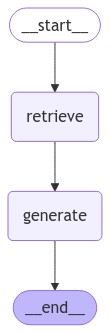

In [13]:
// Note: tslab only works inside a jupyter notebook. Don't worry about running this code yourself!
import * as tslab from "tslab";

const image = await graph.getGraph().drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

<details>
<summary>Do I need to use LangGraph?</summary>

LangGraph is not required to build a RAG application. Indeed, we can implement the same application logic through invocations of the individual components:

```javascript
let question = "..."

const retrievedDocs = await vectorStore.similaritySearch(question)
const docsContent = retrievedDocs.map(doc => doc.pageContent).join("\n");
const messages = await promptTemplate.invoke({ question: question, context: docsContent });
const answer = await llm.invoke(messages);
```

The benefits of LangGraph include:

- Support for multiple invocation modes: this logic would need to be rewritten if we wanted to stream output tokens, or stream the results of individual steps;
- Automatic support for tracing via [LangSmith](https://docs.smith.langchain.com/) and deployments via [LangGraph Platform](https://langchain-ai.github.io/langgraphjs/concepts/langgraph_platform/);
- Support for persistence, human-in-the-loop, and other features.

Many use-cases demand RAG in a conversational experience, such that a user can receive context-informed answers via a stateful conversation. As we will see in [Part 2](/docs/tutorials/qa_chat_history) of the tutorial, LangGraph's management and persistence of state simplifies these applications enormously.

</details>

#### Usage

Let's test our application! LangGraph supports multiple invocation modes, including sync, async, and streaming.

Invoke:

In [14]:
let inputs = { question: "What is Task Decomposition?" };

const result = await graph.invoke(inputs);
console.log(result.context.slice(0, 2));
console.log(`\nAnswer: ${result["answer"]}`);

[
  Document {
    pageContent: 'hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach ut

Stream steps:

In [15]:
console.log(inputs)
console.log("\n====\n");
for await (
  const chunk of await graph.stream(inputs, {
    streamMode: "updates",
  })
) {
  console.log(chunk);
  console.log("\n====\n");
}

{ question: 'What is Task Decomposition?' }

====

{
  retrieve: { context: [ [Document], [Document], [Document], [Document] ] }
}

====

{
  generate: {
    answer: 'Task decomposition is the process of breaking down complex tasks into smaller, more manageable steps. This can be achieved through various methods, including prompting large language models (LLMs) or using task-specific instructions. Techniques like Chain of Thought (CoT) and Tree of Thoughts further enhance this process by structuring reasoning and exploring multiple possibilities at each step.'
  }
}

====



Stream [tokens](/docs/concepts/tokens/):

In [16]:
const stream = await graph.stream(
  inputs,
  { streamMode: "messages" },
);

for await (const [message, _metadata] of stream) {
  process.stdout.write(message.content + "|");
}

|Task| decomposition| is| the| process| of| breaking| down| complex| tasks| into| smaller|,| more| manageable| steps|.| This| can| be| achieved| through| techniques| like| Chain| of| Thought| (|Co|T|),| which| guides| models| to| think| step| by| step|,| or| by| using| specific| prompts| and| human| inputs|.| The| Tree| of| Thoughts| approach| further| enhances| this| by| exploring| multiple| reasoning| possibilities| at| each| step|,| creating| a| structured| tree| of| thoughts|.||

#### Returning sources

Note that by storing the retrieved context in the state of the graph, we recover sources for the model's generated answer in the `"context"` field of the state. See [this guide](/docs/how_to/qa_sources/) on returning sources for more detail.

#### Go deeper

[Chat models](/docs/concepts/chat_models) take in a sequence of messages and return a message.

- [Docs](/docs/how_to#chat-models)
- [Integrations](/docs/integrations/chat/): 25+ integrations to choose from.

**Customizing the prompt**

As shown above, we can load prompts (e.g., [this RAG
prompt](https://smith.langchain.com/hub/rlm/rag-prompt)) from the prompt
hub. The prompt can also be easily customized. For example:

In [18]:
const template = `Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:`

const promptTemplate = ChatPromptTemplate.fromMessages(
  [
    ["user", template]
  ]
)

## Query analysis

So far, we are executing the retrieval using the raw input query. However, there are some advantages to allowing a model to generate the query for retrieval purposes. For example:

- In addition to semantic search, we can build in structured filters (e.g., "Find documents since the year 2020.");
- The model can rewrite user queries, which may be multifaceted or include irrelevant language, into more effective search queries.

[Query analysis](/docs/concepts/retrieval/#query-analysis) employs models to transform or construct optimized search queries from raw user input. We can easily incorporate a query analysis step into our application. For illustrative purposes, let's add some metadata to the documents in our vector store. We will add some (contrived) sections to the document which we can filter on later.

In [17]:
const totalDocuments = allSplits.length;
const third = Math.floor(totalDocuments / 3);

allSplits.forEach((document, i) => {
    if (i < third) {
        document.metadata["section"] = "beginning";
    } else if (i < 2 * third) {
        document.metadata["section"] = "middle";
    } else {
        document.metadata["section"] = "end";
    }
});

allSplits[0].metadata;

{
  source: 'https://lilianweng.github.io/posts/2023-06-23-agent/',
  loc: { lines: { from: 1, to: 1 } },
  section: 'beginning'
}


We will need to update the documents in our vector store. We will use a simple [MemoryVectorStore](https://api.js.langchain.com/classes/langchain.vectorstores_memory.MemoryVectorStore.html) for this, as we will use some of its specific features (i.e., metadata filtering). Refer to the vector store [integration documentation](/docs/integrations/vectorstores/) for relevant features of your chosen vector store.

In [18]:
import { MemoryVectorStore } from "langchain/vectorstores/memory";

const vectorStoreQA = new MemoryVectorStore(embeddings);
await vectorStoreQA.addDocuments(allSplits)

Let's next define a schema for our search query. We will use [structured output](/docs/concepts/structured_outputs/) for this purpose. Here we define a query as containing a string query and a document section (either "beginning", "middle", or "end"), but this can be defined however you like.

In [19]:
type Search = {
  query: string;
  section: string;
};


const structuredLlm = llm.withStructuredOutput({
  name: "Search",
  description: "Search query.",
  parameters: {
    title: "Search",
    type: "object",
    properties: {
      query: { type: "string", description: "Search query to run." },
      section: { 
        enum: ["beginning", "middle", "end"],
        type: "string",
        description: "Section to query."
      },
    },
    required: ["query", "section"],
  },
});

Finally, we add a step to our LangGraph application to generate a query from the user's raw input:

In [21]:
const StateAnnotationQA = Annotation.Root({
  question: Annotation<string>,
  // highlight-start
  search: Annotation<Search>,
  // highlight-end
  context: Annotation<Document[]>,
  answer: Annotation<string>,
});


// highlight-start
const analyzeQuery = async (state: typeof InputStateAnnotation.State) => {
  const result = await structuredLlm.invoke(state.question)
  // return { query: result.query, section: result.section };
  return { search: result }
};
// highlight-end


const retrieveQA = async (state: typeof StateAnnotationQA.State) => {
  // highlight-start
  const filter = (doc) => doc.metadata.section === state.search.section;
  const retrievedDocs = await vectorStore.similaritySearch(
    state.search.query,
    2,
    filter
  )
  // highlight-end
  return { context: retrievedDocs };
};


const generateQA = async (state: typeof StateAnnotationQA.State) => {
  const docsContent = state.context.map(doc => doc.pageContent).join("\n");
  const messages = await promptTemplate.invoke({ question: state.question, context: docsContent });
  const response = await llm.invoke(messages);
  return { answer: response.content };
};



const graphQA = new StateGraph({
  input: InputStateAnnotation,
  output: StateAnnotationQA,
  stateSchema: StateAnnotationQA,
})
  .addNode("analyzeQuery", analyzeQuery)
  .addNode("retrieveQA", retrieveQA)
  .addNode("generateQA", generateQA)
  .addEdge("__start__", "analyzeQuery")
  .addEdge("analyzeQuery", "retrieveQA")
  .addEdge("retrieveQA", "generateQA")
  .addEdge("generateQA", "__end__")
  .compile();

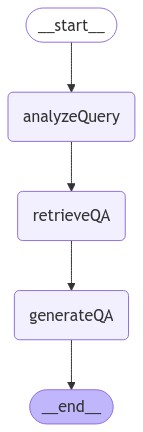

In [22]:
// Note: tslab only works inside a jupyter notebook. Don't worry about running this code yourself!
import * as tslab from "tslab";

const imageQA = await graphQA.getGraph().drawMermaidPng();
const arrayBufferQA = await imageQA.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBufferQA));

We can test our implementation by specifically asking for context from the end of the post. Note that the model includes different information in its answer.

In [23]:
let inputsQA = { question: "What does the end of the post say about Task Decomposition?" };

console.log(inputsQA)
console.log("\n====\n");
for await (
  const chunk of await graphQA.stream(inputsQA, {
    streamMode: "updates",
  })
) {
  console.log(chunk);
  console.log("\n====\n");
}

{
  question: 'What does the end of the post say about Task Decomposition?'
}

====

{
  analyzeQuery: { search: { query: 'Task Decomposition', section: 'end' } }
}

====

{ retrieveQA: { context: [ [Document], [Document] ] } }

====

{
  generateQA: {
    answer: 'The end of the post emphasizes the importance of task decomposition by outlining a structured approach to organizing code into separate files and functions. It highlights the need for clarity and compatibility among different components, ensuring that each part of the architecture is well-defined and functional. This methodical breakdown aids in maintaining best practices and enhances code readability and manageability.'
  }
}

====



In both the streamed steps and the [LangSmith trace](https://smith.langchain.com/public/8ff4742c-a5d4-41b2-adf9-22915a876a30/r), we can now observe the structured query that was fed into the retrieval step.

Query Analysis is a rich problem with a wide range of approaches. Refer to the [how-to guides](/docs/how_to/#query-analysis) for more examples.

## Next steps

We've covered the steps to build a basic Q&A app over data:

- Loading data with a [Document Loader](/docs/concepts/document_loaders)
- Chunking the indexed data with a [Text Splitter](/docs/concepts/text_splitters) to make it more easily usable by a model
- [Embedding the data](/docs/concepts/embedding_models) and storing the data in a [vectorstore](/docs/how_to/vectorstores)
- [Retrieving](/docs/concepts/retrievers) the previously stored chunks in response to incoming questions
- Generating an answer using the retrieved chunks as context.

In [Part 2](/docs/tutorials/qa_chat_history) of the tutorial, we will extend the implementation here to accommodate conversation-style interactions and multi-step retrieval processes.

Further reading:

- [Return sources](/docs/how_to/qa_sources): Learn how to return source documents
- [Streaming](/docs/how_to/streaming): Learn how to stream outputs and intermediate steps
- [Add chat history](/docs/how_to/message_history): Learn how to add chat history to your app
- [Retrieval conceptual guide](/docs/concepts/retrieval): A high-level overview of specific retrieval techniques